In [1]:
import os
import sys

import openpyxl
import random
random.seed(42)

import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../../util"))
from data_utils import *
from plot_utils import *

In [2]:
filename = "../../data/BicyclesRelocationData.xlsx"
wb = openpyxl.load_workbook(filename, data_only=True)

cat_sheet = wb["Categories"]
categories = [cell.value for cell in next(cat_sheet.iter_rows(min_row=1, max_row=1))]
row_surplus = next(cat_sheet.iter_rows(min_row=2, max_row=2))
row_space   = next(cat_sheet.iter_rows(min_row=3, max_row=3))

s = {cat: int(row_surplus[i].value) for i, cat in enumerate(categories)}
c = {cat: float(row_space[i].value) for i, cat in enumerate(categories)}

destinos = []
p = {}
for sheet_name in wb.sheetnames:
    if sheet_name.startswith("ExpectedProfitsArea"):
        ws = wb[sheet_name]
        dest_num = sheet_name[len("ExpectedProfitsArea"):]
        area = "Area" + dest_num
        if area not in destinos:
            destinos.append(area)
        header = [cell.value for cell in next(ws.iter_rows(min_row=1, max_row=1))]
        rows = list(ws.iter_rows(min_row=2, values_only=True))
        for i, cat in enumerate(header):
            profits = [row[i] for row in rows if row[i] is not None]
            p[(cat, area)] = profits

In [3]:
gene_order = [(i, j) for i in categories for j in destinos]
gene_bounds = {(i, j): (0, s[i]) for (i, j) in gene_order}

def compute_total_profit(i, j, allocation):
    """
    Add the first N values ​​of the list of expected profits.
    """
    profits = p.get((i, j), [])
    return sum(profits[:allocation]) 

def evaluate(individual):
    """
    Evaluates the solution and applies penalties for invalid allocations.
    """
    sol = {key: individual[idx] for idx, key in enumerate(gene_order)}
    profit = sum(compute_total_profit(i, j, sol[(i, j)]) for (i, j) in gene_order)

    penalty = 0
    for i in categories:
        total_alloc = sum(sol[(i, j)] for j in destinos)
        if total_alloc > s[i]:  
            penalty += (total_alloc - s[i]) * 1000  # Penalty

    return profit - penalty

In [4]:
# Define GA operators functions

def create_individual():

    individual = []
    for key in gene_order:
        lb, ub = gene_bounds[key]
        individual.append(random.randint(lb, ub))
    return individual

def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Tournament_selection operator

    Args:
        population ([type]): [description]
        fitnesses ([type]): [description]
        tournament_size (int, optional): [description]. Defaults to 3.
    """
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0][:]

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    """
        Uniform_crossover selection

    Args:
        parent1 ([type]): [description]
        parent2 ([type]): [description]
        crossover_prob (float, optional): [description]. Defaults to 0.5.
    """
    child1, child2 = parent1[:], parent2[:]
    for i in range(len(parent1)):
        if random.random() < crossover_prob:
            child1[i], child2[i] = child2[i], child1[i]
    return child1, child2

def mutate(individual, mutation_prob=0.2):
    """
    Mutate selection

    Args:
        individual ([type]): [description]
        mutation_prob (float, optional): [description]. Defaults to 0.2.
    """
    mutant = individual[:]
    for idx, key in enumerate(gene_order):
        if random.random() < mutation_prob:
            lb, ub = gene_bounds[key]
            mutant[idx] = random.randint(lb, ub)
    return mutant

In [6]:
def genetic_algorithm(pop_size=1000, generations=1000, crossover_prob=0.7, mutation_prob=0.7, tournament_size=3):
    """
    GA implementation

    Args:
        pop_size (int, optional): [description]. Defaults to 1000.
        generations (int, optional): [description]. Defaults to 1000.
        crossover_prob (float, optional): [description]. Defaults to 0.7.
        mutation_prob (float, optional): [description]. Defaults to 0.7.
    """
    population = [create_individual() for _ in range(pop_size)]
    best_solution = None
    best_fitness = float('-inf')
    fitness_history = []  
    
    for gen in range(generations):
        fitnesses = [evaluate(ind) for ind in population]
        
        for ind, fit in zip(population, fitnesses):
            if fit > best_fitness:
                best_fitness = fit
                best_solution = ind[:]
        
        fitness_history.append(best_fitness)
        print(f"Generation {gen}: Best fitness = {best_fitness}")
        
        new_population = []
        while len(new_population) < pop_size:
            
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)

            child1, child2 = uniform_crossover(parent1, parent2, crossover_prob)

            child1 = mutate(child1, mutation_prob)
            child2 = mutate(child2, mutation_prob)

            new_population.extend([child1, child2])
        
        population = new_population[:pop_size]
    
    return best_solution, best_fitness, fitness_history

In [7]:
%%time

best_sol, best_fit, fitness_history = genetic_algorithm()

Generation 0: Best fitness = -2004611.6883
Generation 1: Best fitness = -2004611.6883
Generation 2: Best fitness = -2004611.6883
Generation 3: Best fitness = -2004611.6883
Generation 4: Best fitness = -2004611.6883
Generation 5: Best fitness = -1912692.1404
Generation 6: Best fitness = -1912692.1404
Generation 7: Best fitness = -1912692.1404
Generation 8: Best fitness = -1912692.1404
Generation 9: Best fitness = -1912692.1404
Generation 10: Best fitness = -1912692.1404
Generation 11: Best fitness = -1912692.1404
Generation 12: Best fitness = -1912692.1404
Generation 13: Best fitness = -1912692.1404
Generation 14: Best fitness = -1912692.1404
Generation 15: Best fitness = -1912692.1404
Generation 16: Best fitness = -1912692.1404
Generation 17: Best fitness = -1912692.1404
Generation 18: Best fitness = -1912692.1404
Generation 19: Best fitness = -1912692.1404
Generation 20: Best fitness = -1912692.1404
Generation 21: Best fitness = -1897808.7744
Generation 22: Best fitness = -1897808.774

In [8]:
solution_dict = {key: best_sol[idx] for idx, key in enumerate(gene_order)}

print(f"Best solution (allocations by (Category, Destination)):")
for key, value in solution_dict.items():
    print(f"{key}: {value}")

print(f"Best solution raw fitness (profit minus penalty): {best_fit}")

Best solution (allocations by (Category, Destination)):
('Child', 'Area1'): 49
('Child', 'Area2'): 33
('Child', 'Area3'): 31
('Child', 'Area4'): 146
('Child', 'Area5'): 59
('Child', 'Area6'): 57
('Child', 'Area7'): 8
('Adult', 'Area1'): 45
('Adult', 'Area2'): 19
('Adult', 'Area3'): 155
('Adult', 'Area4'): 78
('Adult', 'Area5'): 54
('Adult', 'Area6'): 25
('Adult', 'Area7'): 80
('Electric', 'Area1'): 276
('Electric', 'Area2'): 62
('Electric', 'Area3'): 66
('Electric', 'Area4'): 41
('Electric', 'Area5'): 38
('Electric', 'Area6'): 53
('Electric', 'Area7'): 58
('Racing', 'Area1'): 133
('Racing', 'Area2'): 29
('Racing', 'Area3'): 109
('Racing', 'Area4'): 46
('Racing', 'Area5'): 114
('Racing', 'Area6'): 162
('Racing', 'Area7'): 141
('Mountain', 'Area1'): 202
('Mountain', 'Area2'): 241
('Mountain', 'Area3'): 8
('Mountain', 'Area4'): 75
('Mountain', 'Area5'): 87
('Mountain', 'Area6'): 76
('Mountain', 'Area7'): 19
('Tricycle', 'Area1'): 49
('Tricycle', 'Area2'): 37
('Tricycle', 'Area3'): 60
('Tr

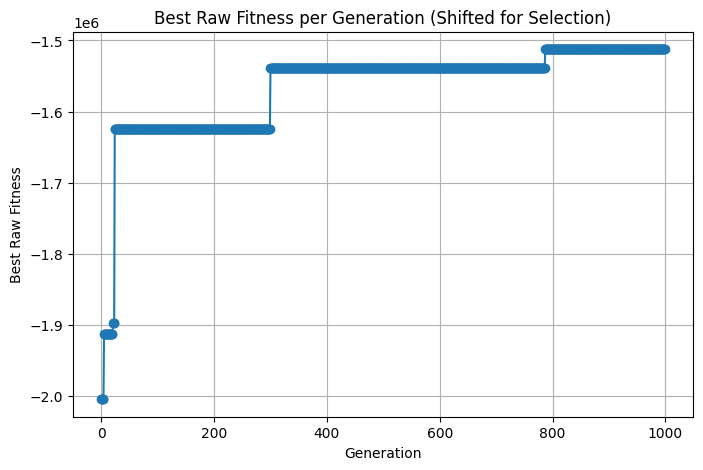

In [9]:
plot_fitness_history(fitness_history)